# Simulation analysis - growth reward pool
## Saturn Aliens

### Maria Silva, October 2022

In this simulation, we assume that the initial reward pool provided by PL will be split through time based on network growth. In other words, as the number of participants grow, and they collectively contribute with more bandwidth, we will increase the total rewards available in a given day.

In [1]:
import os
import sys
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath('../src/'))
from treasury_sim.sim import run_single_sim
from treasury_sim import metrics

import warnings
warnings.filterwarnings('ignore')

## 1. Design details 

Note that for this simulation we are focussing on the L1 node operators and their payouts. 

* **Operator types (performance distribution will be based out of real data!):**
    * Honest high-performing L1 operator (10%)
    * Honest average L1 operator (75%)
    * Honest low-performing L1 operator (10%)
    * Cheating L1 operator (5%)
* **Simulation forecast:** 6 months
* **Simulation parameters:**
    * Log detection performance:
        * FPR: 1%
        * Recall 25%
    * Penalty size:
        * 5x average reward
        * 7x average reward
    * Payout frequency:
        * Once per day
    * Scoring functions
        * Direct multiplication
        * Bandwidth exponent: $k_1 \in \{0.5, 1, 2\}$ -> how much do we want to distribute rewards evenly?
        * Uptime and speed exponents: $k_2 \in \{0.5, 1, 2\}$ -> how severe should performance "penalties" be?
    * Initial reward pool investment:
        * For how long should we subsidize it? -> 6 months
        * How much should it pay? -> rough numbers are 100k dollars per month (or 20k FIL at current price)
    * Initial set of operators
        * 50
    * New operators' inflow (i.e. new operators entering the network)
        * 5 per day

**Define parameters**

In [2]:
# Fixed
n_months = 6
sim_len = n_months * 30 
initial_ops_num = 50
new_ops_num = 6
total_pool = 20000.0 * n_months # 20k FIL per month
is_growth_pool = True

# Variable
k1_list = [0.5, 1.0, 2.0]
k2_list = [0.5, 1.0, 2.0]
penalty_mult_list = [5.0, 7.0]

## 2. Run simulation

In [3]:
full_sim_df = pd.DataFrame()
full_traj_df = pd.DataFrame()
param_grid = itertools.product(k1_list, k2_list, penalty_mult_list)

for k1, k2, penalty_mult in param_grid:
    ops_list = run_single_sim(sim_len, k1, k2, penalty_mult, [], initial_ops_num, new_ops_num, is_growth_pool, total_pool)
    sim_df = metrics.compute_sim_metrics(ops_list, k1=k1, k2=k2, penalty_multiplier=penalty_mult)
    full_sim_df = pd.concat([full_sim_df, sim_df], ignore_index=True)
    traj_df = metrics.compute_ops_trajectory(ops_list, sim_len, k1=k1, k2=k2, penalty_multiplier=penalty_mult)
    full_traj_df = pd.concat([full_traj_df, traj_df], ignore_index=True)

**Quick data processing**

In [4]:
# Process sim stats
full_sim_df["k1"] = full_sim_df["k1"].astype(str)
full_sim_df["k2"] = full_sim_df["k2"].astype(str)
full_sim_df["penalty_multiplier"] = full_sim_df["penalty_multiplier"].astype(str)
full_sim_df["score_function"] = "k1=" + full_sim_df["k1"] + " " + "k2=" + full_sim_df["k2"]
full_sim_df["Operator type"] = full_sim_df["op_type"].replace({"honest_low_l1": "Low perf.", 
                                                               "honest_normal_l1": "Normal perf.",
                                                               "cheating_l1": "Cheating",
                                                               "honest_high_l1": "High perf."})
full_sim_df.head()

,op_type,num_payouts,missed_payouts,total_payout,avg_payout,median_payout,total_penalty,num_penalties,avg_penalty,max_no_penalty_period,collateral_balance,total_bandwidth,k1,k2,penalty_multiplier,score_function,Operator type
0,honest_normal_l1,170,10,194.456755,1.143863,1.143916,5.817018,1,5.817018,113,5.800670,162.249219,0.5,0.5,5.0,k1=0.5 k2=0.5,Normal perf.
1,honest_normal_l1,167,13,186.709151,1.118019,1.126800,11.818043,2,5.909022,139,5.913120,159.897867,0.5,0.5,5.0,k1=0.5 k2=0.5,Normal perf.
2,honest_normal_l1,176,4,199.498512,1.133514,1.132522,0.000000,0,0.000000,180,6.093583,161.837253,0.5,0.5,5.0,k1=0.5 k2=0.5,Normal perf.
3,honest_high_l1,162,18,222.269773,1.372036,1.376027,21.006093,3,7.002031,79,6.951749,215.378841,0.5,0.5,5.0,k1=0.5 k2=0.5,High perf.
4,honest_normal_l1,162,18,181.849258,1.122526,1.116608,16.511398,3,5.503799,116,5.706977,159.467092,0.5,0.5,5.0,k1=0.5 k2=0.5,Normal perf.


In [5]:
# Process traj data
full_traj_df["sim_step"] = full_traj_df["sim_step"].astype(int)
full_traj_df["payout"] = full_traj_df["payout"].astype(float)
full_traj_df["penalty"] = full_traj_df["penalty"].astype(float)
full_traj_df["flag"] = full_traj_df["flag"].astype(bool)
full_traj_df["k1"] = full_traj_df["k1"].astype(str)
full_traj_df["k2"] = full_traj_df["k2"].astype(str)
full_traj_df["penalty_multiplier"] = full_traj_df["penalty_multiplier"].astype(str)
full_traj_df["score_function"] = "k1=" + full_traj_df["k1"] + " " + "k2=" + full_traj_df["k2"]
full_traj_df["Operator type"] = full_traj_df["op_type"].replace({"honest_low_l1": "Low perf.", 
                                                               "honest_normal_l1": "Normal perf.",
                                                               "cheating_l1": "Cheating",
                                                               "honest_high_l1": "High perf."})

full_traj_df.head()

,sim_step,op_type,payout,flag,penalty,bandwidth,k1,k2,penalty_multiplier,score_function,Operator type
0,0,honest_normal_l1,0.0,False,0.0,0.759548,0.5,0.5,5.0,k1=0.5 k2=0.5,Normal perf.
1,1,honest_normal_l1,0.0,False,0.0,0.665944,0.5,0.5,5.0,k1=0.5 k2=0.5,Normal perf.
2,2,honest_normal_l1,0.0,False,0.0,0.869257,0.5,0.5,5.0,k1=0.5 k2=0.5,Normal perf.
3,3,honest_normal_l1,0.0,False,0.0,0.905795,0.5,0.5,5.0,k1=0.5 k2=0.5,Normal perf.
4,4,honest_normal_l1,0.0,False,0.0,0.875358,0.5,0.5,5.0,k1=0.5 k2=0.5,Normal perf.


In [6]:
sum_traj_df = (full_traj_df
               .groupby(["sim_step", "k1", "k2", "penalty_multiplier", "score_function"])
               .sum()
               .reset_index()
              )
sum_traj_df.head()

,sim_step,k1,k2,penalty_multiplier,score_function,payout,flag,penalty,bandwidth
0,0,0.5,0.5,5.0,k1=0.5 k2=0.5,0.0,0,0.000000,44.521132
1,0,0.5,0.5,7.0,k1=0.5 k2=0.5,0.0,2,18.864987,46.837935
2,0,0.5,1.0,5.0,k1=0.5 k2=1.0,0.0,0,0.000000,44.514468
3,0,0.5,1.0,7.0,k1=0.5 k2=1.0,0.0,0,0.000000,44.811069
4,0,0.5,2.0,5.0,k1=0.5 k2=2.0,0.0,0,0.000000,42.236255


**Define op types pallete**

In [7]:
palette_colors = sns.color_palette('Set2', n_colors=4)
ops_types = ['Low perf.', 'Normal perf.', 'High perf.', 'Cheating']
op_types_palette = {op_type: color for op_type, color in zip(ops_types, palette_colors)}

## 3. Capital deployment

Let's explore to see how capital is deployed and how it flows to the participants.
In particular, we plot the time-evolution of deployed capital and penalties, and we show the total sums for each parameter setting.

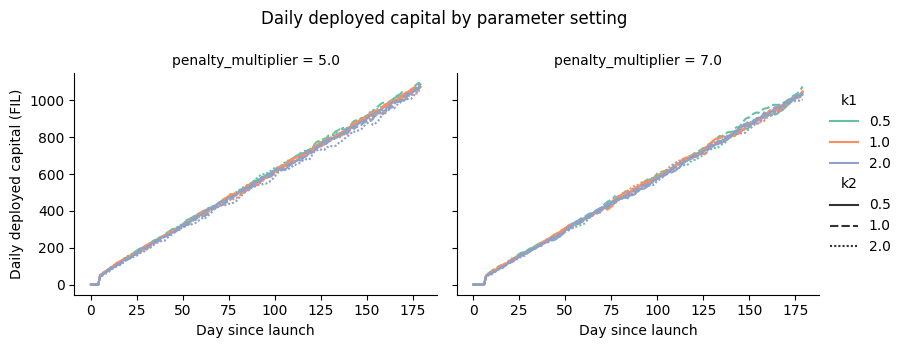

In [30]:
g = sns.relplot(x="sim_step", y="payout", col="penalty_multiplier", hue="k1",style="k2",
            data=sum_traj_df, kind="line", aspect=1.2, height=3.5, palette="Set2")
g.set_axis_labels("Day since launch", "Daily deployed capital (FIL)")
g.fig.suptitle('Daily deployed capital by parameter setting')
g.fig.subplots_adjust(top=0.8)
plt.show()

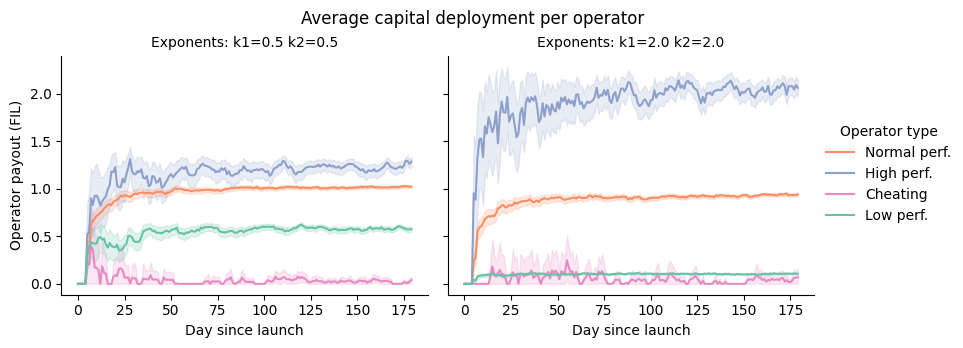

In [9]:
temp_df = full_traj_df[full_traj_df["score_function"].isin(["k1=0.5 k2=0.5", "k1=2.0 k2=2.0"])]
g = sns.relplot(x="sim_step", y="payout", hue="Operator type", col="score_function",
                data=temp_df, aspect=1.2, height=3.5, kind="line", palette=op_types_palette)
g.set_axis_labels("Day since launch", "Operator payout (FIL)")
g.set_titles("Exponents: {col_name}")
g.fig.suptitle('Average capital deployment per operator')
g.fig.subplots_adjust(top=0.85)
plt.show()

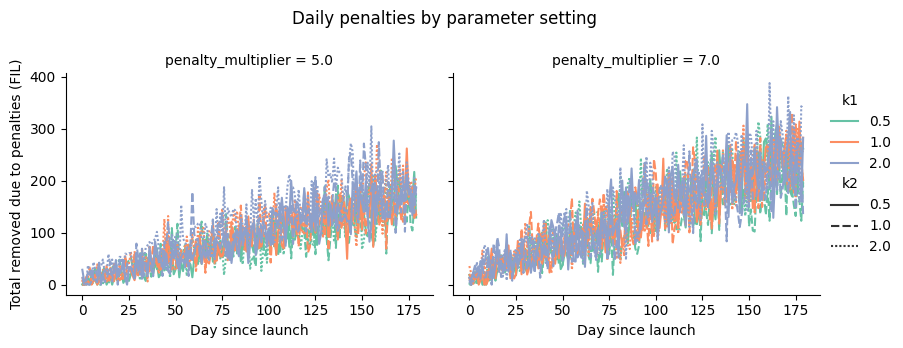

In [10]:
g = sns.relplot(x="sim_step", y="penalty", col="penalty_multiplier", hue="k1",style="k2",
            data=sum_traj_df, kind="line", aspect=1.2, height=3.5, palette="Set2")
g.set_axis_labels("Day since launch", "Total removed due to penalties (FIL)")
g.fig.suptitle('Daily penalties by parameter setting')
g.fig.subplots_adjust(top=0.8)
plt.show()

**Total deployed capital and total penalties:**

In [11]:
total_df = sum_traj_df.groupby(["penalty_multiplier","k1", "k2"])[["penalty", "payout"]].sum()
total_df["capital_loss_ratio"] = total_df["penalty"]/(total_df["penalty"]+total_df["payout"])
total_df

penalty         payout  capital_loss_ratio
penalty_multiplier k1  k2                                                  
5.0                0.5 0.5  15045.742415  100167.407438            0.130590
                       1.0  14793.082672  100144.473276            0.128705
                       2.0  13913.331838  100722.719873            0.121370
                   1.0 0.5  15567.161902   99831.148838            0.134899
                       1.0  16266.349670   99039.726321            0.141071
                       2.0  18715.502650   97613.327258            0.160884
                   2.0 0.5  17070.900072   98601.643619            0.147580
                       1.0  18438.568672   97766.705059            0.158672
                       2.0  22139.797124   94852.931268            0.189241
7.0                0.5 0.5  23823.421966   93819.625133            0.202506
                       1.0  18610.927484   96484.560494            0.161700
                       2.0  25948.704961   92714.577072            0.218675
                   1.0 0.5  23030.346468   94428.194125            0.196072
                       1.0  25356.570730   93219.501712            0.213842
                       2.0  23247.362122   94370.403039            0.197652
                   2.0 0.5  25215.199292   93173.688338            0.212986
                       1.0  22918.873294   93709.700821            0.196512
                       2.0  27412.373615   92427.553741            0.228742

### Key Takeaways:

* Daily deployed capital growths in a stable trend through time. The random variations around this trend come from the normal variation on the operators being detected by the log detection system and the differences in total bandwidth committed.
* Looking at the daily deployed capital per operator, we see a constant trend. This is expected since we designed the daily pool to grow with bandwidth.
* Daily deployed capital takes some days to reach the stable trend. This is caused by the withholding of rewards to build the collateral balance.
* The scoring functions don't seem to have a meaning impact on daily deployed capital or daily penalties.
* The penalty multiplier has a direct impact on both daily deployed capital and penalties. A multiplier of 5x leads to 10%-15% of the total initial capital to not be deployed due to penalties. This value is 15%-25% for a multiplier of 7x. This raises the question of what to do with this unused capital?

## 4. Capital distribution among honest operators

Now, we explore how capital is being distributed among honest operators and how the different scoring functions impact that distribution. We also look into penalties and how the log detection system and penalty multiplier impacts the rewards received by honest operators.

In [12]:
honest_sim_df = full_sim_df[full_sim_df["op_type"] != "cheating_l1"]
honest_sim_df["penalty_ratio"] = honest_sim_df["total_penalty"]/(honest_sim_df["total_penalty"]+honest_sim_df["total_payout"])
honest_sim_df["penalty_ratio"] = honest_sim_df["penalty_ratio"].fillna(0)                                  
honest_sim_df["op_type"] = honest_sim_df["op_type"].replace({"honest_low_l1": "Low perf.", 
                                                             "honest_normal_l1": "Normal perf.",
                                                             "honest_high_l1": "High perf."})

honest_traj_df = full_traj_df[full_traj_df["op_type"] != "cheating_l1"]
honest_traj_df["op_type"] = honest_traj_df["op_type"].replace({"honest_low_l1": "Low perf.", 
                                                             "honest_normal_l1": "Normal perf.",
                                                             "honest_high_l1": "High perf."})

### Daily payouts (average)

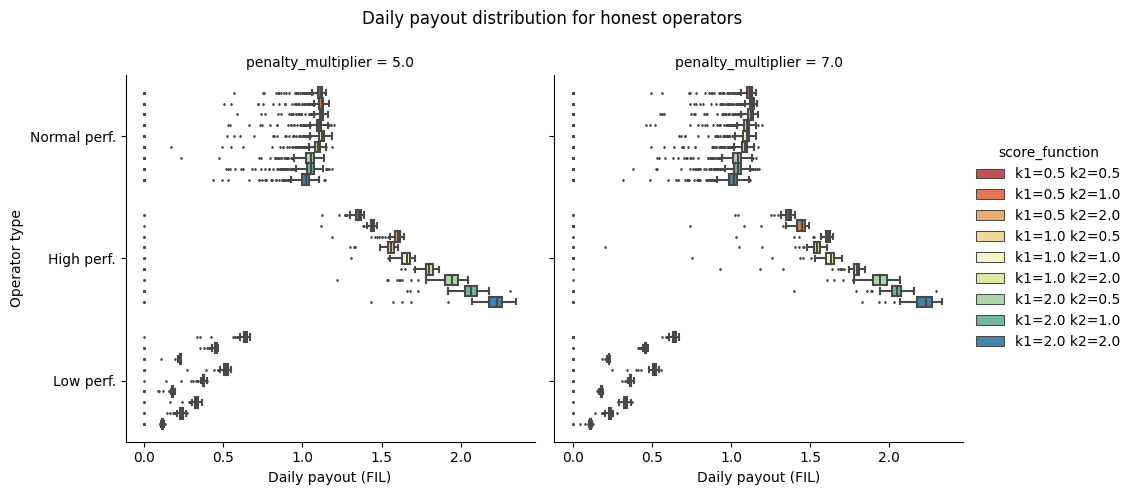

In [33]:
g = sns.catplot(y="op_type", x="avg_payout", hue="score_function", col="penalty_multiplier",
                kind="box", data=honest_sim_df, fliersize=1, palette="Spectral")
g.set_axis_labels("Daily payout (FIL)", "Operator type")
g.fig.suptitle('Daily payout distribution for honest operators')
g.fig.subplots_adjust(top=0.85)
plt.show()

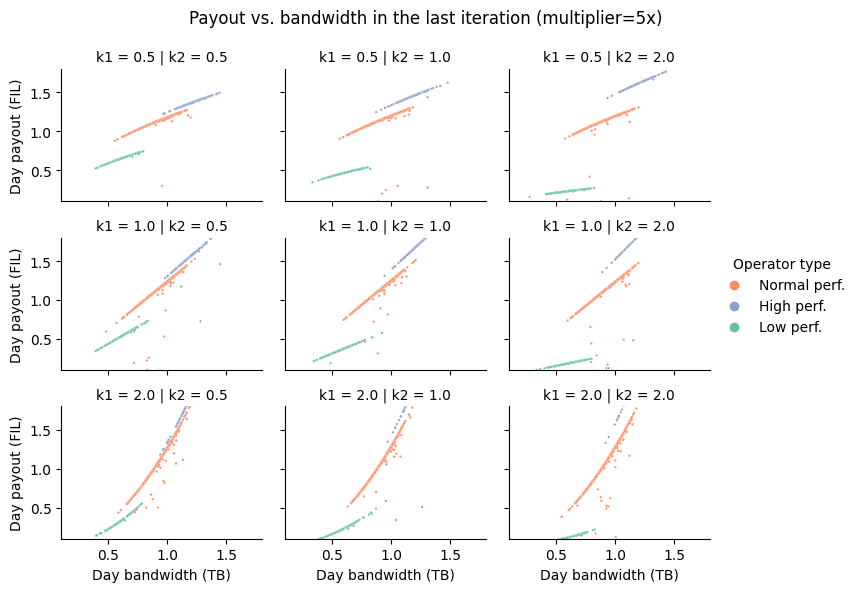

In [14]:
temp_df = honest_traj_df[honest_traj_df["penalty_multiplier"]=="5.0"]
temp_df = temp_df[temp_df["sim_step"] == 179]
temp_df["Operator type"] = temp_df["op_type"]
g = sns.relplot(x="bandwidth", y="payout", hue="Operator type", col="k2", row="k1", height=2, aspect=1.2,
                data=temp_df, kind="scatter", s=3, palette=op_types_palette)
g.set(xlim=(0.1, 1.8), ylim=(0.1, 1.8))
g.set_axis_labels("Day bandwidth (TB)", "Day payout (FIL)")
g.fig.suptitle('Payout vs. bandwidth in the last iteration (multiplier=5x)')
g.fig.subplots_adjust(top=0.88)
plt.show()

### Total payout

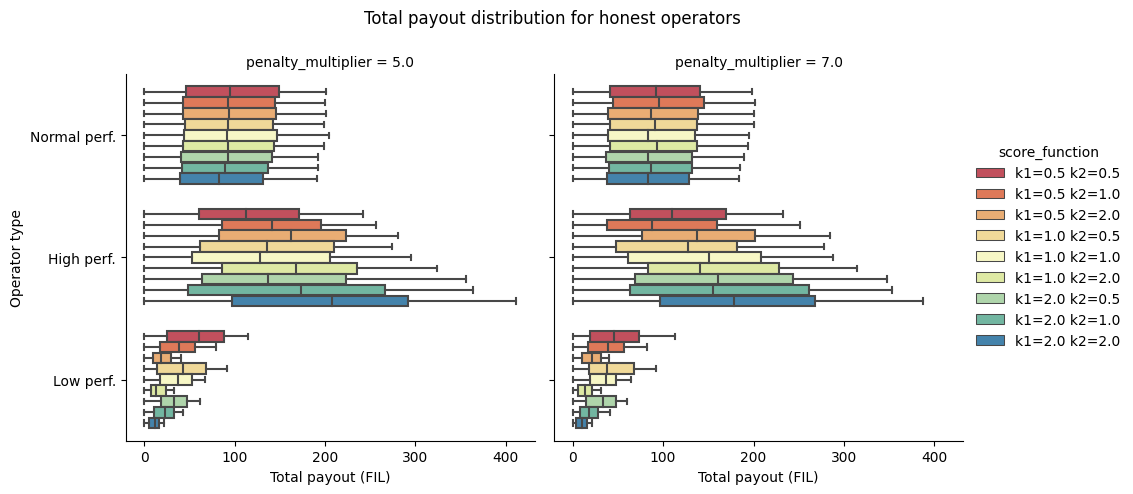

In [15]:
g = sns.catplot(y="op_type", x="total_payout", hue="score_function", col="penalty_multiplier",
                kind="box", data=honest_sim_df, fliersize=1, palette="Spectral")
g.set_axis_labels("Total payout (FIL)", "Operator type")
g.fig.suptitle('Total payout distribution for honest operators')
g.fig.subplots_adjust(top=0.85)
plt.show()

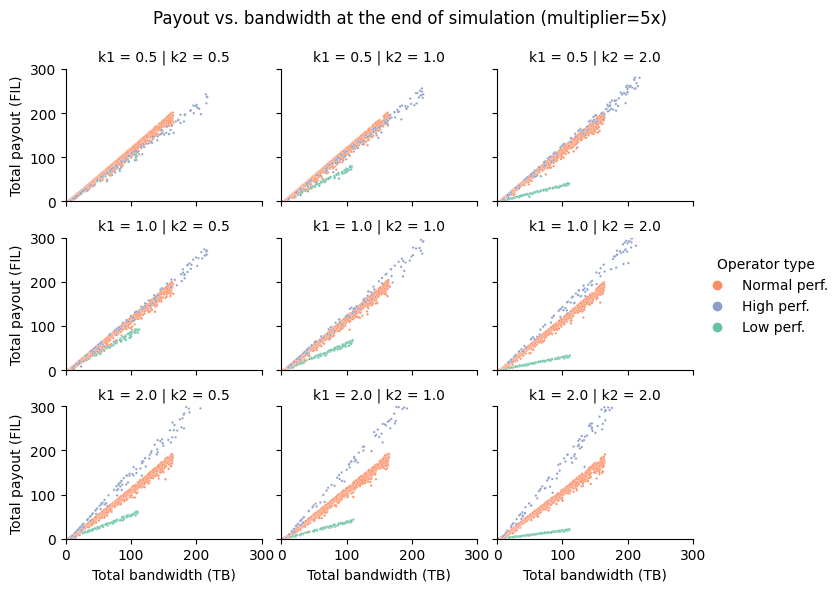

In [16]:
temp_df = honest_sim_df[honest_sim_df["penalty_multiplier"]=="5.0"]
temp_df["Operator type"] = temp_df["op_type"]
g = sns.relplot(x="total_bandwidth", y="total_payout", hue="Operator type", col="k2", row="k1", 
                height=2, aspect=1.2, data=temp_df, kind="scatter", s=3, palette=op_types_palette)
g.set(xlim=(0, 300), ylim=(0, 300))
g.set_axis_labels("Total bandwidth (TB)", "Total payout (FIL)")
g.fig.suptitle('Payout vs. bandwidth at the end of simulation (multiplier=5x)')
g.fig.subplots_adjust(top=0.88)
plt.show()

### Cumulative payout evolution

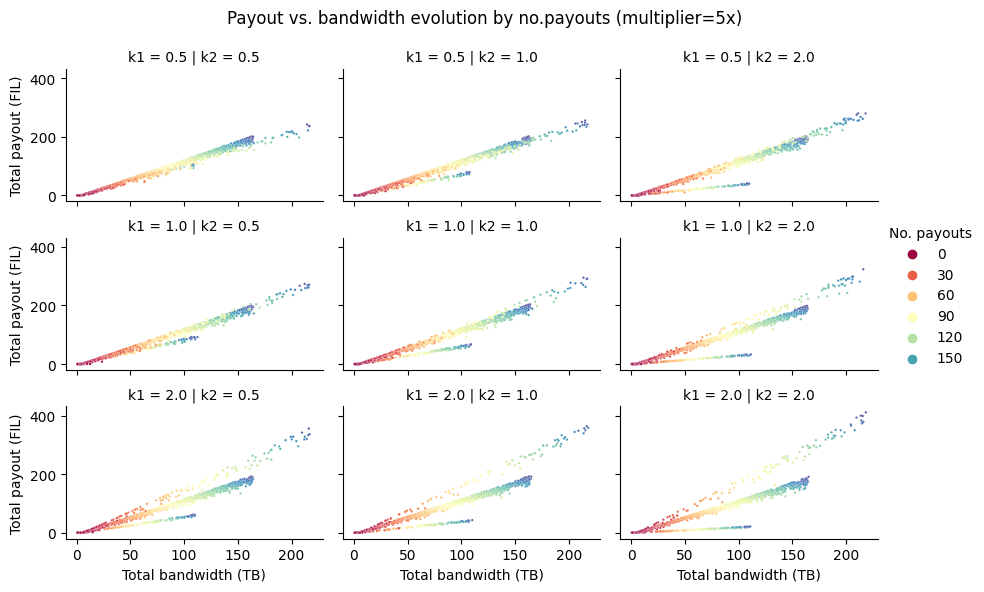

In [17]:
temp_df = honest_sim_df[honest_sim_df["penalty_multiplier"]=="5.0"]
temp_df["No. payouts"] = temp_df["num_payouts"]
g = sns.relplot(x="total_bandwidth", y="total_payout", hue="No. payouts", col="k2", row="k1", 
                height=2, aspect=1.5, data=temp_df, kind="scatter", s=3, palette="Spectral")
g.set_axis_labels("Total bandwidth (TB)", "Total payout (FIL)")
g.fig.suptitle('Payout vs. bandwidth evolution by no.payouts (multiplier=5x)')
g.fig.subplots_adjust(top=0.88)
plt.show()

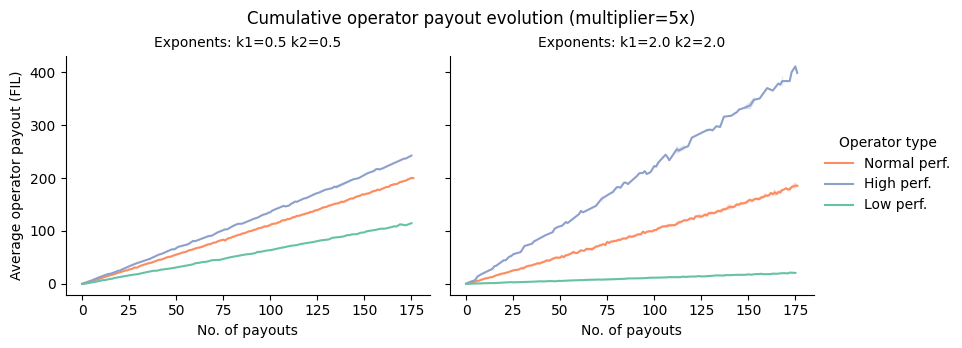

In [46]:
temp_df = honest_sim_df[honest_sim_df["score_function"].isin(["k1=0.5 k2=0.5", "k1=2.0 k2=2.0"])]
temp_df = temp_df[temp_df["penalty_multiplier"]=="5.0"]
g = sns.relplot(x="num_payouts", y="total_payout", hue="Operator type", col="score_function",
                data=temp_df, aspect=1.2, height=3.5, kind="line", palette=op_types_palette)
g.set_axis_labels("No. of payouts", "Average operator payout (FIL)")
g.set_titles("Exponents: {col_name}")
g.fig.suptitle('Cumulative operator payout evolution (multiplier=5x)')
g.fig.subplots_adjust(top=0.85)
plt.show()

### Penalties

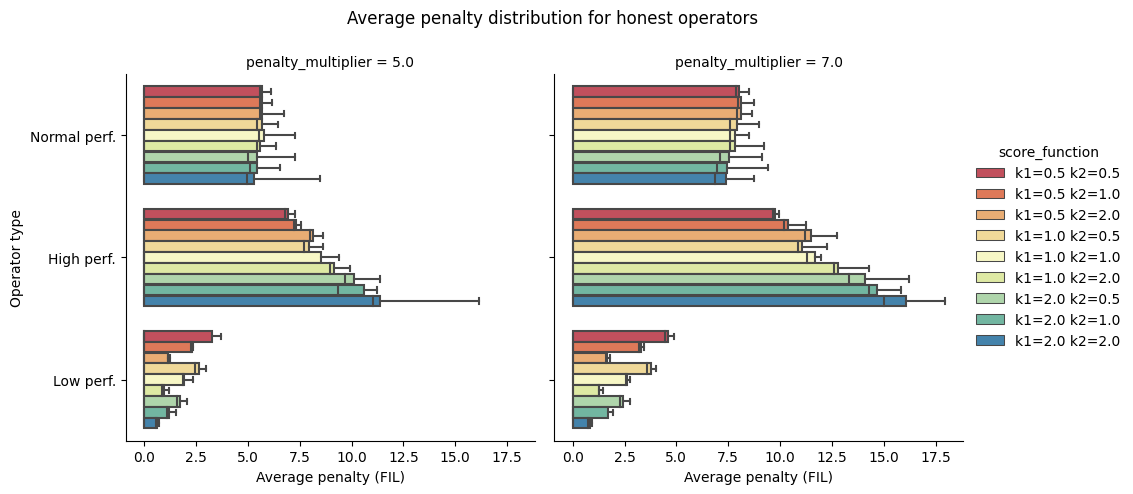

In [19]:
g = sns.catplot(y="op_type", x="avg_penalty", hue="score_function", col="penalty_multiplier",
                kind="box", data=honest_sim_df, fliersize=1, palette="Spectral")
g.set_axis_labels("Average penalty (FIL)", "Operator type")
g.fig.suptitle('Average penalty distribution for honest operators')
g.fig.subplots_adjust(top=0.85)
plt.show()

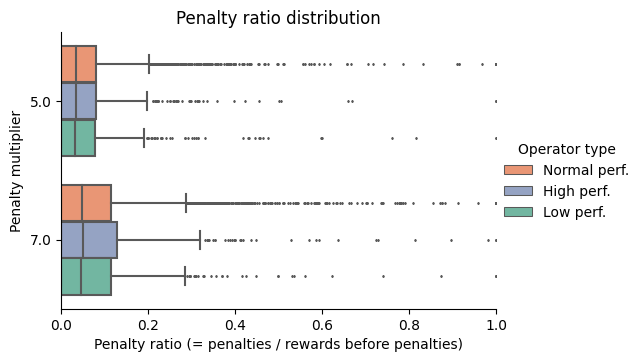

In [20]:
g = sns.catplot(y="penalty_multiplier", x="penalty_ratio", hue="Operator type",height=3.5,aspect=1.5,
                kind="box", data=honest_sim_df[honest_sim_df["penalty_ratio"]<np.inf], fliersize=1, palette=op_types_palette)
g.set(xlim=(0, 1))
g.set_axis_labels("Penalty ratio (= penalties / rewards before penalties)", "Penalty multiplier")
plt.title('Penalty ratio distribution')
plt.show()

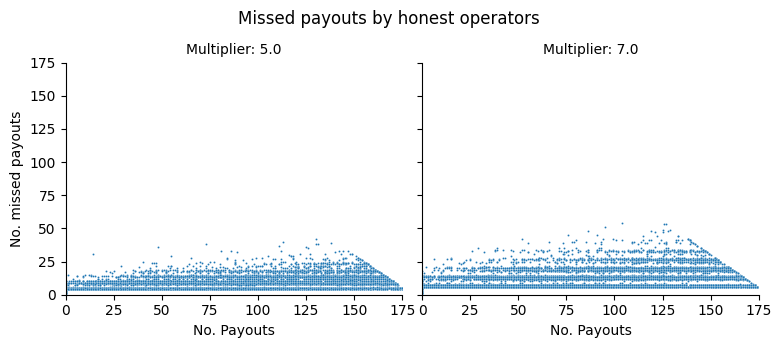

In [21]:
g = sns.relplot(x="num_payouts", y="missed_payouts", col="penalty_multiplier",
                height=3.5, aspect=1.1, data=honest_sim_df, kind="scatter", s=2)
g.set_axis_labels("No. Payouts", "No. missed payouts")
g.set(xlim=(0, 175), ylim=(0, 175))
g.set_titles("Multiplier: {col_name}")
g.fig.suptitle('Missed payouts by honest operators')
g.fig.subplots_adjust(top=0.83)
plt.show()

### Key Takeaways:

* As expected, performance has an impact on the payout to operators, with high performing operators getting higher rewards, followed by the normal operators, which are followed by the low performing operators.
* Looking at how the scoring functions impact reward distribution, we notice the following:
    * Low exponents distribute rewards more evenly among the operators, while high exponents reward more high performance over low performance.
    * With $k_1=2$, eve the normal nodes get affected by received lower rewards when compared with the other parameter settings
    * Low performing operators get a bigger impact from a high $k_2$ than a high $k_1$
* As expected, honest operators still experience penalties. When they are applied, penalties are higher for high performances since their average reward is also higher.
* With a multiplier or 5x, most operators experience a total penalty lower than 20% of the total payout. With a multiplier of 7x, this percentage increases to 30%.

## 5. Value extracted by cheating operators

Finally, we focus on the cheating operators and analyze how much value they extract from the network. We also analyze how the multiplier impacts rewards to these operators.

In [22]:
cheat_sim_df = full_sim_df[full_sim_df["op_type"] == "cheating_l1"]
cheat_sim_df.loc[:,"Got paid"] = np.where(cheat_sim_df["num_payouts"]>0, "Yes", "No")
cheat_sim_df["penalty_ratio"] = (
    cheat_sim_df["total_penalty"]/(cheat_sim_df["total_penalty"]+cheat_sim_df["total_payout"])
).fillna(0)

In [57]:
cheat_sum_df = (
    cheat_sim_df
    .groupby(["penalty_multiplier","score_function"])
    [["total_payout", "total_penalty"]]
    .sum()
)
cheat_sum_df["count"] = cheat_sim_df.groupby(["penalty_multiplier","score_function"]).size()
cheat_sum_df["avg_payout"] = cheat_sum_df["total_payout"] / cheat_sum_df["count"] 
cheat_sum_df

total_payout  total_penalty  count  \
penalty_multiplier score_function                                       
5.0                k1=0.5 k2=0.5     228.812751    9620.298185     68   
                   k1=0.5 k2=1.0     287.757316    9191.494862     47   
                   k1=0.5 k2=2.0     223.377603    8222.627659     50   
                   k1=1.0 k2=0.5     271.283771   10120.985661     53   
                   k1=1.0 k2=1.0     393.303104   10677.862021     50   
                   k1=1.0 k2=2.0     255.767259   13394.255187     62   
                   k1=2.0 k2=0.5     169.521331   11725.542406     51   
                   k1=2.0 k2=1.0     430.596254   12924.219631     51   
                   k1=2.0 k2=2.0     325.664626   16515.139527     52   
7.0                k1=0.5 k2=0.5     119.725459   15790.220302     69   
                   k1=0.5 k2=1.0      26.672697   10577.956423     46   
                   k1=0.5 k2=2.0     139.386414   18376.260788     61   
                   k1=1.0 k2=0.5     123.224684   15127.122695     60   
                   k1=1.0 k2=1.0     106.725198   17458.953153     56   
                   k1=1.0 k2=2.0      98.790582   15194.757114     58   
                   k1=2.0 k2=0.5      99.523859   17765.774251     51   
                   k1=2.0 k2=1.0      32.993352   14859.554217     44   
                   k1=2.0 k2=2.0     129.801524   20197.198693     54   

                                   avg_payout  
penalty_multiplier score_function              
5.0                k1=0.5 k2=0.5     3.364893  
                   k1=0.5 k2=1.0     6.122496  
                   k1=0.5 k2=2.0     4.467552  
                   k1=1.0 k2=0.5     5.118562  
                   k1=1.0 k2=1.0     7.866062  
                   k1=1.0 k2=2.0     4.125278  
                   k1=2.0 k2=0.5     3.323948  
                   k1=2.0 k2=1.0     8.443064  
                   k1=2.0 k2=2.0     6.262781  
7.0                k1=0.5 k2=0.5     1.735152  
                   k1=0.5 k2=1.0     0.579841  
                   k1=0.5 k2=2.0     2.285023  
                   k1=1.0 k2=0.5     2.053745  
                   k1=1.0 k2=1.0     1.905807  
                   k1=1.0 k2=2.0     1.703286  
                   k1=2.0 k2=0.5     1.951448  
                   k1=2.0 k2=1.0     0.749849  
                   k1=2.0 k2=2.0     2.403732

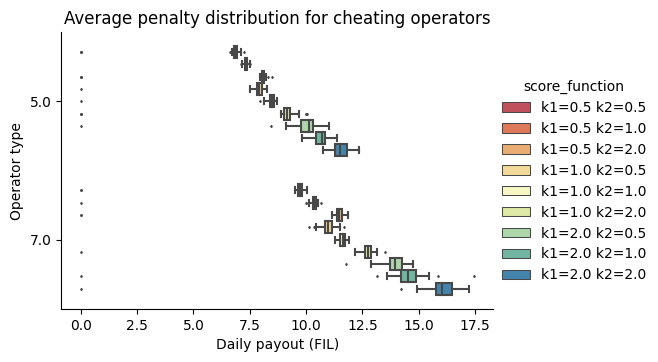

In [25]:
g = sns.catplot(x="avg_penalty", y="penalty_multiplier",hue="score_function", height=3.5,aspect=1.5,
                kind="box", data=cheat_sim_df, fliersize=1, palette="Spectral")
g.set_axis_labels("Daily payout (FIL)", "Operator type")
plt.title('Average penalty distribution for cheating operators')
plt.show()

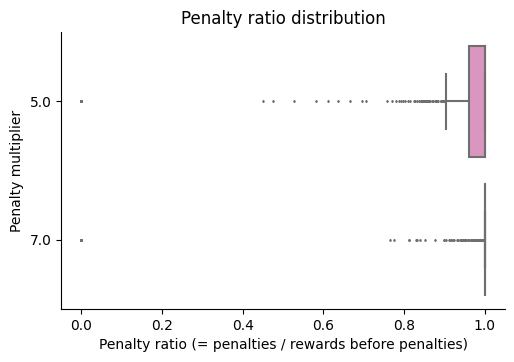

In [26]:
g = sns.catplot(y="penalty_multiplier", x="penalty_ratio",height=3.5,aspect=1.5,
                kind="box", data=cheat_sim_df, fliersize=1, color=op_types_palette["Cheating"])
g.set_axis_labels("Penalty ratio (= penalties / rewards before penalties)", "Penalty multiplier")
plt.title('Penalty ratio distribution')
plt.show()

In [27]:
temp_df = cheat_sim_df.groupby(["Got paid", "penalty_multiplier"]).size()

print(temp_df["Yes"]/(temp_df["Yes"]+temp_df["No"]))

temp_df.reset_index()

penalty_multiplier
5.0    0.456612
7.0    0.206413
dtype: float64


,Got paid,penalty_multiplier,0
0,No,5.0,263
1,No,7.0,396
2,Yes,5.0,221
3,Yes,7.0,103


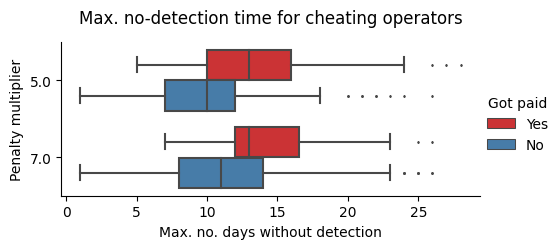

In [28]:
g = sns.catplot(y="penalty_multiplier", x="max_no_penalty_period", hue="Got paid",
                kind="box", data=cheat_sim_df, fliersize=1, palette="Set1", aspect=2, height=2.5)
g.set_axis_labels("Max. no. days without detection", "Penalty multiplier")
g.fig.suptitle('Max. no-detection time for cheating operators')
g.fig.subplots_adjust(top=0.85)
plt.show()

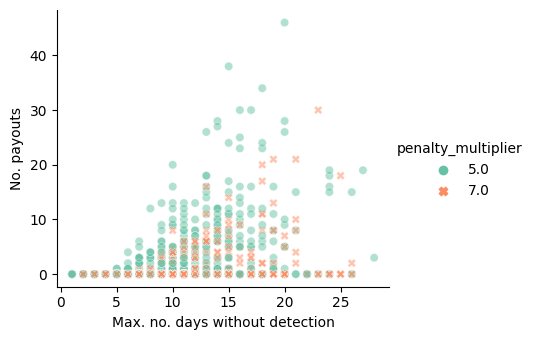

In [29]:
g = sns.relplot(x="max_no_penalty_period", y="num_payouts", style="penalty_multiplier",kind="scatter",alpha=0.5,
                hue="penalty_multiplier", data=cheat_sim_df, palette="Set2", aspect=1.2, height=3.5)
g.set_axis_labels("Max. no. days without detection", "No. payouts")
plt.show()

### Key Takeaways:

* As expected, the penalty multiplier has a significant impact on the value cheating operators are able to extract from the network.
    * With a multiplier of 5x, these operators can collectively extract between 200 and 400 FIL during the 6 months. This is an average of 0.4 FIL per operator. In addition, 43.1% of the operators get at least one payout.
    * With a multiplier of 7x, these operators can collectively extract between 50 and 150 FIL during the 6 months. This is an average of 0.15 FIL per operator. In addition, 16.5% of the operators get at least one payout.
* Looking at the penalty ratio for these operators, we see that a majority of them gets a ratio higher than 95% (with most having a ratio of 1).

## 6. Additional plots

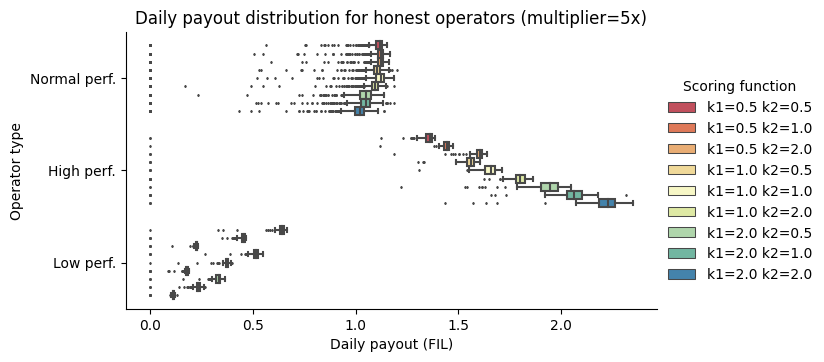

In [45]:
temp_df = honest_sim_df[honest_sim_df["penalty_multiplier"]=="5.0"]
temp_df["Scoring function"] = temp_df["score_function"]
g = sns.catplot(y="op_type", x="avg_payout", hue="Scoring function",aspect=2, height=3.5,
                kind="box", data=temp_df, fliersize=1, palette="Spectral")
g.set_axis_labels("Daily payout (FIL)", "Operator type")
plt.title('Daily payout distribution for honest operators (multiplier=5x)')
plt.show()

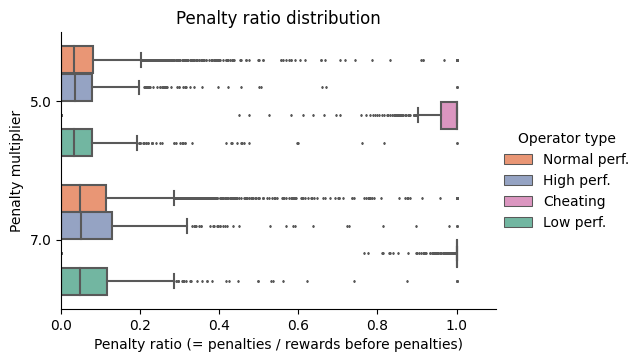

In [31]:
temp_df = full_sim_df
temp_df["penalty_ratio"] = temp_df["total_penalty"]/(temp_df["total_penalty"]+temp_df["total_payout"])
temp_df["penalty_ratio"] = temp_df["penalty_ratio"].fillna(0)
temp_df = full_sim_df[full_sim_df["penalty_ratio"]<np.inf]

g = sns.catplot(y="penalty_multiplier", x="penalty_ratio", hue="Operator type",height=3.5,aspect=1.5,
                kind="box", data=temp_df, fliersize=1, palette=op_types_palette)
g.set(xlim=(0, 1.1))
g.set_axis_labels("Penalty ratio (= penalties / rewards before penalties)", "Penalty multiplier")
plt.title('Penalty ratio distribution')
plt.show()

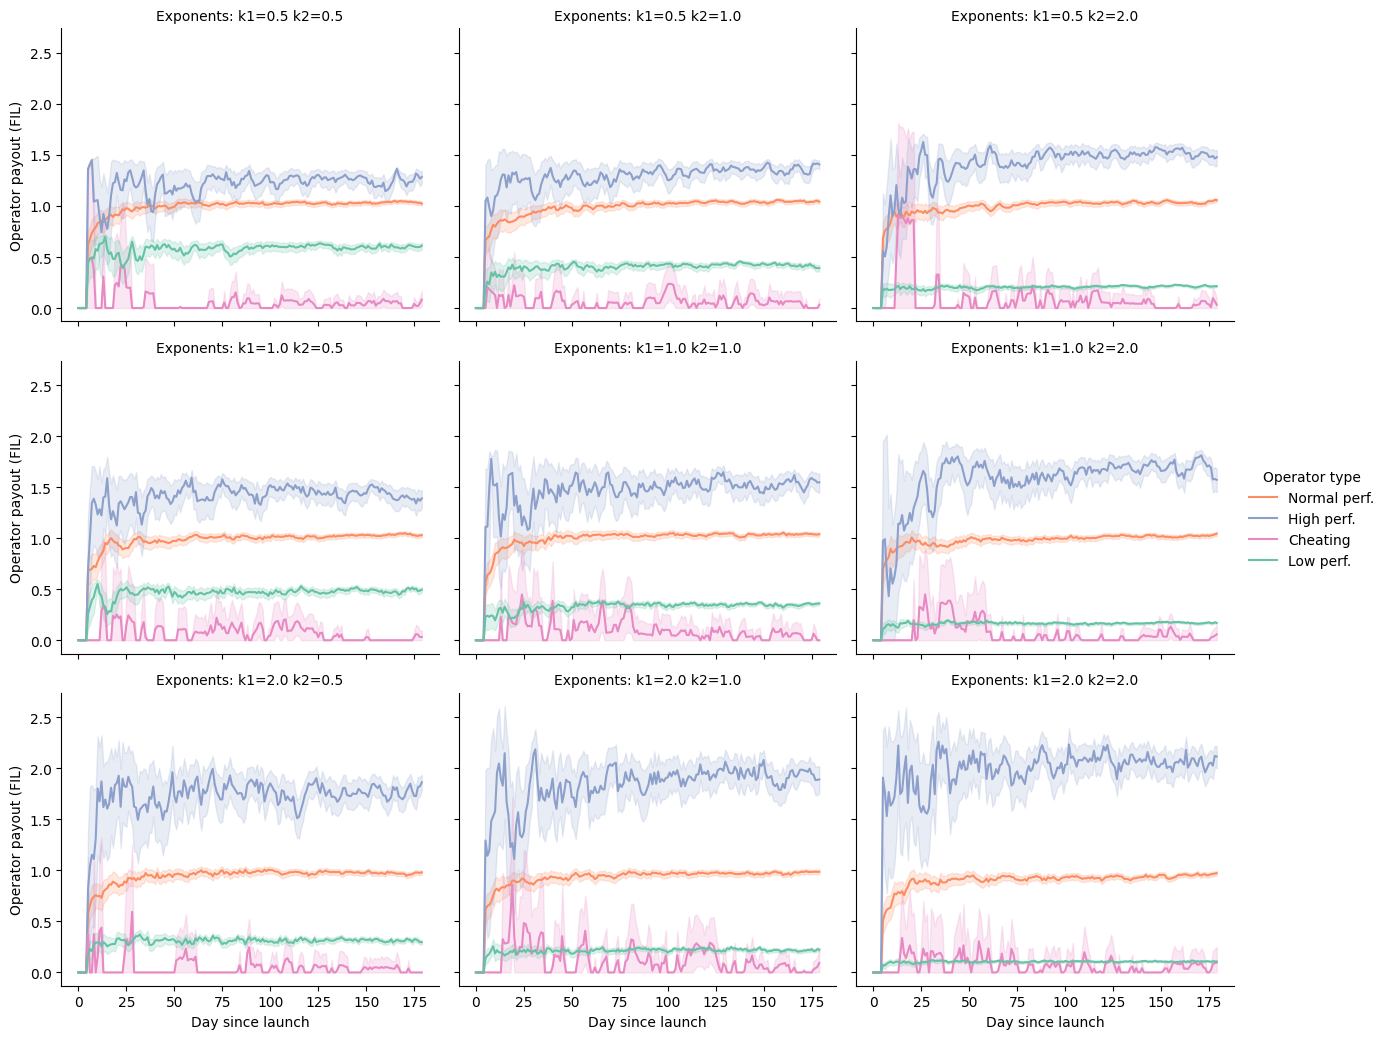

In [51]:
temp_df = full_traj_df[full_traj_df["penalty_multiplier"]=="5.0"]
g = sns.relplot(x="sim_step", y="payout", hue="Operator type", col="score_function",col_wrap=3,
                data=temp_df, aspect=1.2, height=3.5, kind="line", palette=op_types_palette)
g.set_axis_labels("Day since launch", "Operator payout (FIL)")
g.set_titles("Exponents: {col_name}")
plt.show()